<a href="https://colab.research.google.com/github/CanKeles5/SequenceModels/blob/main/TEIA%C5%9E_LSTM_predict_NG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

To-Do:
  Train using only one feature. NaturalGas

  Inspect the data and drop columns that are too sparse. See how many of the values in each col are zero.

++++ 1-  Give all features except total and natural gas and predict NG.


2-  Use 1-2 years data and do forecasting. 

In [ ]:
import torch
torch.cuda.is_available()
if torch.cuda.is_available():
  dev = "cuda:0"
else:
  dev = "cpu"
device = torch.device(dev)

In [ ]:
device

device(type='cuda', index=0)

In [ ]:
%matplotlib inline

In [ ]:
! pip install pickle5

     |████████████████████████████████| 133kB 7.5MB/s 
  Created wheel for pickle5: filename=pickle5-0.0.11-cp37-cp37m-linux_x86_64.whl size=219251 sha256=c63f9437d867b1688dbcd66aff16db307bdc3ba60fbd5df7c66a8fa0a7b03d93
  Stored in directory: /root/.cache/pip/wheels/a6/90/95/f889ca4aa8b0e0c7f21c8470b6f5d6032f0390a3a141a9a3bd
Successfully built pickle5


In [ ]:
import pickle5
from math import sqrt
from datetime import datetime
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
with open('/content/20210101-epias-raw.pkl', 'rb') as f:
    data = pickle5.load(f)

Drop all colums of zeros: df.loc[:, (df != 0).any(axis=0)]


In [ ]:
new_data = data.loc[:, (data != 0).any(axis=0)] #(index=False)

In [ ]:
new_data.shape

(67268, 24)

In [ ]:
new_data = new_data[0:67268-24*300]

In [ ]:
new_data.shape

(60068, 24)

In [ ]:
new_data

,date,fueloil,blackCoal,lignite,geothermal,naturalGas,river,dammedHydro,lng,biomass,naphta,importCoal,asphaltiteCoal,wind,sun,importExport,total,ltotal,lwind,lbiogas,lcanalType,lbiomass,lsun,lothers
0,2013-05-01 00:00:00,29.2,0.00,551.00,0.00,2326.01,151.49,502.38,9.3,26.35,0.0,1184.00,0.00,2.00,0.0,0.0,4781.73,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,2013-05-01 01:00:00,29.1,0.00,544.00,0.00,2334.78,152.77,441.94,9.3,27.07,0.0,1184.00,0.00,2.00,0.0,0.0,4724.96,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2,2013-05-01 02:00:00,29.1,0.00,547.00,0.00,2157.76,151.47,430.19,9.3,26.88,0.0,1185.00,0.00,2.00,0.0,0.0,4538.70,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
3,2013-05-01 03:00:00,29.0,0.00,547.00,0.00,2084.72,125.83,275.18,9.4,25.67,0.0,1183.00,0.00,1.00,0.0,0.0,4280.80,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
4,2013-05-01 04:00:00,28.3,0.00,549.00,0.00,2034.68,124.35,271.86,9.4,26.45,0.0,1066.00,0.00,1.00,0.0,0.0,4111.04,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60063,2020-03-07 19:00:00,36.1,280.96,4351.81,1085.50,1819.41,4371.78,11958.95,0.0,458.16,0.0,7990.04,339.04,2971.57,0.0,239.0,35902.32,52.2281,13.2950,16.9841,4.1684,14.4191,3.0673,0.2942
60064,2020-03-07 20:00:00,35.7,285.53,4349.41,1100.85,1809.92,4341.69,11481.08,0.0,459.27,0.0,7983.78,340.02,2968.33,0.0,163.0,35318.58,48.6524,13.1804,16.9642,4.0431,13.9582,0.3931,0.1134
60065,2020-03-07 21:00:00,36.2,301.52,4360.10,1107.39,1749.12,4336.44,10677.39,0.0,464.02,0.0,7975.81,335.60,3013.95,0.0,169.0,34526.54,48.5306,13.3514,16.9729,3.9932,13.7144,0.3676,0.1311
60066,2020-03-07 22:00:00,36.4,307.80,4052.46,1115.12,1651.82,4313.39,9225.29,0.0,455.99,0.0,7968.84,335.60,3179.01,0.0,98.0,32739.72,49.5955,14.2639,16.9540,4.1900,13.7055,0.3663,0.1158


In [ ]:
new_data = new_data.sample(frac = 1) #shuffles the rows.

In [ ]:
new_data = new_data.drop(['date', 'ltotal',	'lwind',	'lbiogas',	'lcanalType',	'lbiomass',	'lsun',	'lothers', 'total'], axis=1)

In [ ]:
new_data

,fueloil,blackCoal,lignite,geothermal,naturalGas,river,dammedHydro,lng,biomass,naphta,importCoal,asphaltiteCoal,wind,sun,importExport
840,29.80,150.0,1159.50,0.00,8849.86,100.49,519.84,9.1,57.96,0.0,788.00,0.00,13.27,0.00,0.00
49064,202.30,346.5,4700.38,920.78,12024.41,2167.92,5480.09,0.0,301.19,0.0,7283.15,362.10,3987.91,27.10,-429.36
46985,174.50,187.5,5209.15,707.36,11590.17,1014.10,4204.60,0.0,262.04,0.0,7269.58,181.04,2321.88,0.00,374.00
17633,289.10,212.5,2678.28,235.08,9818.52,4655.62,6187.50,9.4,124.60,0.0,4456.85,134.68,1094.48,0.00,0.00
49221,226.00,343.0,5440.32,856.46,9139.21,2699.42,2461.73,0.0,309.89,0.0,7640.83,245.08,1334.30,0.00,-415.28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3044,21.80,258.0,3024.93,0.00,11920.38,81.09,5012.08,9.3,51.28,0.0,2502.00,0.00,275.31,0.00,0.00
8557,275.73,285.5,4445.35,223.53,13173.84,2590.00,4869.73,8.5,113.54,4.0,3845.74,134.68,662.61,0.00,0.00
39234,168.20,360.5,4778.98,722.06,15011.31,1050.87,2372.62,0.0,235.91,0.0,6242.23,341.67,639.47,0.00,0.00
53167,177.80,339.5,4897.55,885.58,4001.95,4991.20,11612.74,0.0,346.20,0.0,5173.02,258.33,853.10,73.02,-330.63


In [ ]:
target = new_data.drop(['fueloil',	'blackCoal',	'lignite',	'geothermal',	'river',	'dammedHydro',	'lng',	'biomass',	'naphta',	'importCoal',	'asphaltiteCoal',	'wind',	'sun',	'importExport'], axis=1)

In [ ]:
target = target.to_numpy()

In [ ]:
data = new_data.drop(['naturalGas'], axis=1)

In [ ]:
data = data.to_numpy()

To-do:
  Get the data in such a format that it can work with the other notebook.
  
  1- Extract the date element.

  2- Normalize all features in the input part of the data.

  3- Create the inputs and the targets.

  4- Create train and test sets.

  5- 

  6- 

In [ ]:
# integer encode direction
#encoder = LabelEncoder()
#new_data[:,4] = encoder.fit_transform(new_data[:,4])
# ensure all data is float

#values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)
target = scaler.fit_transform(target)

print(data.shape)
print(target.shape)
#reframed = series_to_supervised(scaled, n_hours, 1)
#print(reframed.shape)

(60068, 14)
(60068, 1)


In [ ]:
train_x = data[0:42000]
train_y = target[0:42000]

val_x = data[42000:54000]
val_y = target[42000:54000]

test_x = data[54000:60068]
test_y = target[54000:60068]

In [ ]:
class LSTM(nn.Module):

  def __init__(self):
    super(LSTM, self).__init__()

    self.lstm = nn.LSTM(input_size=14, hidden_size=300, num_layers=3)
    self.FC = nn.Linear(300, 1)

  def forward(self, input):
    pred, _ = self.lstm(input)

    pred = self.FC(pred.view(300))

    return pred

In [ ]:
model = LSTM().to(device)

In [ ]:
sum(p.numel() for p in model.parameters())

1824301

In [ ]:
loss_function = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=3e-5)

In [ ]:
train_loss_hist = []
val_loss_hist = []

In [ ]:
for epoch in range(200):
  train_loss = 0.0
  val_loss = 0.0

  for i in range(train_x.shape[0]):
    data = torch.Tensor(train_x[i]).unsqueeze(0).unsqueeze(0)    
    data = data.to(device)

    model.train()
    optimizer.zero_grad()

    prediction = model(data)

    #print("Train --- prediction: " + str(prediction) + " , GT: " + str(train_y[i]))

    loss = loss_function(prediction, torch.Tensor([train_y[i]]).to(device))

    train_loss += loss.item()

    loss.backward()
    optimizer.step()

  with torch.no_grad():
    for i in range(val_x.shape[0]):
      data = torch.Tensor(val_x[i]).unsqueeze(0).unsqueeze(0)
      data = data.to(device)

      prediction = model(data)

      #print("Validate --- prediction: " + str(prediction) + " , GT: " + str(val_y[i]))

      loss = loss_function(prediction, torch.Tensor([val_y[i]]).to(device))
      val_loss += loss.item()

  train_loss = train_loss / train_x.shape[0]
  val_loss = val_loss / val_x.shape[0]

  train_loss_hist.append(train_loss)
  val_loss_hist.append(val_loss)

  print("Epoch " + str(epoch) + " ---> Train loss: " +  str(train_loss) + " --- Validation loss: " + str(val_loss))


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:94: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Epoch 0 ---> Train loss: 0.10480459952602784 --- Validation loss: 0.09449488945056994
Epoch 1 ---> Train loss: 0.09588630273539041 --- Validation loss: 0.09353409156544755
Epoch 2 ---> Train loss: 0.09543372409914931 --- Validation loss: 0.0940268839088579
Epoch 3 ---> Train loss: 0.09506932270216445 --- Validation loss: 0.09370168436442812
Epoch 4 ---> Train loss: 0.09470532618321123 --- Validation loss: 0.09355578094255179
Epoch 5 ---> Train loss: 0.09431715201666313 --- Validation loss: 0.0930943458713591
Epoch 6 ---> Train loss: 0.09385504376968103 --- Validation loss: 0.09239049497029433
Epoch 7 ---> Train loss: 0.09333612216530102 --- Validation loss: 0.09191963359558333
Epoch 8 ---> Train loss: 0.09273159168944473 --- Validation loss: 0.09158835841808469
Epoch 9 ---> Train loss: 0.09197599082227265 --- Validation loss: 0.09122791695346436
Epoch 10 ---> Train loss: 0.09107695967766145 --- Validation loss: 0.08971186144929379
Epoch 11 ---> Train loss: 0.08997747550833793 --- Valid

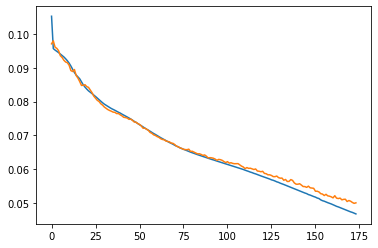

In [ ]:
pyplot.plot(train_loss_hist)
pyplot.plot(val_loss_hist)


In [ ]:
test_loss = 0.0

with torch.no_grad():
  for i in range(test_x.shape[0]):
    data = torch.Tensor(test_x[i]).unsqueeze(0).unsqueeze(0)
    data = data.to(device)

    prediction = model(data)

    print("Prediction: " + str(prediction) + " --- Ground truth: " + str(test_y[i]))

    #print("Validate --- prediction: " + str(prediction) + " , GT: " + str(val_y[i]))

    loss = loss_function(prediction, torch.Tensor([test_y[i]]).to(device))
    test_loss += loss.item()

Prediction: tensor([0.6914], device='cuda:0') --- Ground truth: [0.76579924]
Prediction: tensor([0.8058], device='cuda:0') --- Ground truth: [0.87163488]
Prediction: tensor([0.3753], device='cuda:0') --- Ground truth: [0.40766132]
Prediction: tensor([0.5302], device='cuda:0') --- Ground truth: [0.47208946]
Prediction: tensor([0.6114], device='cuda:0') --- Ground truth: [0.61089534]
Prediction: tensor([0.6504], device='cuda:0') --- Ground truth: [0.62895101]
Prediction: tensor([0.4308], device='cuda:0') --- Ground truth: [0.4238894]
Prediction: tensor([0.5976], device='cuda:0') --- Ground truth: [0.59614871]
Prediction: tensor([0.5984], device='cuda:0') --- Ground truth: [0.69406304]
Prediction: tensor([0.5452], device='cuda:0') --- Ground truth: [0.58103488]
Prediction: tensor([0.6229], device='cuda:0') --- Ground truth: [0.61155256]
Prediction: tensor([0.5639], device='cuda:0') --- Ground truth: [0.55684901]
Prediction: tensor([0.3541], device='cuda:0') --- Ground truth: [0.35395834]


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:94: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Görüntülenen çıkış son 5000 satıra kısaltıldı.
Prediction: tensor([0.6739], device='cuda:0') --- Ground truth: [0.68895867]
Prediction: tensor([0.3593], device='cuda:0') --- Ground truth: [0.39727249]
Prediction: tensor([0.4251], device='cuda:0') --- Ground truth: [0.4718668]
Prediction: tensor([0.6132], device='cuda:0') --- Ground truth: [0.61116852]
Prediction: tensor([0.6207], device='cuda:0') --- Ground truth: [0.63232274]
Prediction: tensor([0.5947], device='cuda:0') --- Ground truth: [0.60376971]
Prediction: tensor([0.5602], device='cuda:0') --- Ground truth: [0.49788542]
Prediction: tensor([0.4840], device='cuda:0') --- Ground truth: [0.49772872]
Prediction: tensor([0.6790], device='cuda:0') --- Ground truth: [0.68989282]
Prediction: tensor([0.7573], device='cuda:0') --- Ground truth: [0.75374653]
Prediction: tensor([0.6464], device='cuda:0') --- Ground truth: [0.56654272]
Prediction: tensor([0.5322], device='cuda:0') --- Ground truth: [0.51319104]
Prediction: tensor([0.5516], d

In [ ]:
print("Test loss is: " + str(test_loss/test_y.shape[0]))

Test loss is: 0.050202627972028686
